#### Install required libraries and tools:

In [ ]:
pip install wandb

In [ ]:
pip install tensorflow

In [ ]:
pip install opencv-python

#### Importing the required libraries

In [1]:
import tensorflow as tf
import keras
from keras import optimizers
from keras.models import Sequential
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from pathlib import Path
import wandb
from wandb.keras import WandbCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

#### Read the X-Ray Scan images of the Training data, validation data and test data after resizing them to 224 * 224 using cv2

In [2]:
directory_train ='train'
directory_val = 'val'
directory_test = 'test'
labels = ['bacterial_pneumonia', 'viral_pneumonia',  'normal']
img_size = 224

def fetch_data(directory):
    data = [] 
    for label in labels: 
        path = os.path.join(directory, label)
        class_num = labels.index(label)
        os.listdir()
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                resized_arr = np.multiply(resized_arr, 1./255)
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    print()
    return np.array(data)

train_data = fetch_data(directory_train)
val_data = fetch_data(directory_val)
test_data = fetch_data(directory_test)

print('train_data.shape - ',train_data.shape)
print('val_data.shape - ',val_data.shape)
print('test_data.shape - ',test_data.shape)

C:\Users\panka\AppData\Local\Temp/ipykernel_7904/1112335968.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)



train_data.shape -  (5200, 2)
val_data.shape -  (24, 2)
test_data.shape -  (624, 2)


In [3]:
# Number of classes is 3 - Normal,Bacterial pneumonia and Viral pneumonia:
number_classes=3
X_train = np.stack(train_data[:,0]).reshape(-1, img_size, img_size).astype('float32')
y_train = to_categorical(np.array(train_data[:,1], dtype='float64'), num_classes=number_classes)
X_val = np.stack(val_data[:,0]).reshape(-1, img_size, img_size).astype('float32')
y_val = to_categorical(np.array(val_data[:,1], dtype='float64'), num_classes=number_classes)
X_test = np.stack(test_data[:,0]).reshape(-1, img_size, img_size).astype('float32')
y_test = to_categorical(np.array(test_data[:,1], dtype='float64'), num_classes=number_classes)
print('train set: ',X_train.shape, y_train.shape)
print('val set: ',X_val.shape, y_val.shape)
print('test set: ',X_test.shape, y_test.shape)

#Deleting the previous variables not needed further in the code, to free up RAM
del(train_data)
del(val_data)
del(test_data)

train set:  (5200, 224, 224) (5200, 3)
val set:  (24, 224, 224) (24, 3)
test set:  (624, 224, 224) (624, 3)


In [4]:
#function definition giving a graph visualizing data balance

def data_balance_graph(y_train, plotting):
  l = []
  for i in np.argmax(y_train, axis=1): # y_train
    if(i == 0):
      l.append("bacterial_pneumonia")
    elif(i == 1):
      l.append("viral_pneumonia")
    elif (i == 2):
      l.append("normal")
    else:
      l.append("unknown")
  if plotting==1:
    sns.set_style('darkgrid')
    sns.countplot(l)
  print("bacterial_pneumonia / viral_pneumonia / normal / unknown")
  print(l.count("bacterial_pneumonia")," / ",l.count("viral_pneumonia")," / ", l.count("normal")," / ", l.count("unknown"))

In [5]:
#function to read and display augmented image (used later)

def plot_image(X_train, y_train):
  fig, axs = plt.subplots(1,3,figsize=(12,4))

  idx = 0
  check = np.zeros(3, dtype='uint8')
  for i in np.argmax(y_train, axis=1): 
    if(check[i]==1): continue
    axs[i].imshow(np.reshape(X_train[idx], (img_size,img_size)), cmap='gray')
    check[i] = 1
    idx += 1
    if(np.sum(check)==3): break
    
  axs[0].set_title("bacterial")
  axs[1].set_title("viral")
  axs[2].set_title("normal")
  for i in range(3):
    axs[i].grid(b=False)

#### Data Pre-Processing

In [6]:
#Albumentations python library used for Data Augmentation

#pip install albumentations
from IPython.display import display, HTML 
from albumentations import (VerticalFlip, HorizontalFlip, Flip, RandomRotate90, Rotate, ShiftScaleRotate, CenterCrop, OpticalDistortion, GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
                            RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise, CLAHE, ChannelShuffle, InvertImg, RandomGamma, ToGray, PadIfNeeded 
                           )
import albumentations as alb

In [7]:
#Initializing the probability of various transformations available under albumentations library and setting the
# values for attributes such as scaling, rotation degrees etc.

alb_config = {
    'target_size': 224,
    'seed': 23,
    'batch_size': 8,
    'enable_preprocessing': False,

    'augm_p_corrections': 0.3,
    'augm_p_contrast': 1,
    'augm_p_gamma': 1,
    'augm_p_brightness': 1,

    'augm_p_blurs': 0.5,
    'augm_p_blur': 1,
    'augm_p_motionblur': 1,
    'augm_p_medianblur': 1,

    'augm_p_distortions': 0.3,
    'augm_p_elastic': 1,
    'augm_p_grid': 1,
    'augm_p_optical': 1,

    'augm_p_shiftscalrot': 0.3,
    'augm_shift_limit': 0.2,
    'augm_scale_limit': 0.1,
    'augm_rotate_limit': 15,
}

In [8]:
#Applying the transformations of albumentations library:

augm = alb.Compose([
        alb.HorizontalFlip(), #Flips the image horizontally along the y-axis
        alb.OneOf([
            alb.RandomGamma(p=alb_config["augm_p_gamma"]),
        ],
            p=alb_config["augm_p_corrections"]),
        alb.OneOf([
            alb.Blur(blur_limit=4, p=alb_config["augm_p_blur"]), #Blur the input image using random-sized kernal
            alb.MotionBlur(blur_limit=4, p=alb_config["augm_p_motionblur"]), #Apply motion blur to the input image using a random-sized kernel
        ],
            p=alb_config["augm_p_blurs"]),
        alb.OneOf([
            alb.ElasticTransform(alpha=60, #
                                 sigma=60 * 0.15,
                                 alpha_affine=60 * 0.03,
                                 p=alb_config["augm_p_elastic"]), #Performs elastic deformation of images
            alb.GridDistortion(p=alb_config["augm_p_grid"]),      ##Performs grid distortions of images
            alb.OpticalDistortion(
                distort_limit=0.3, shift_limit=0.1, p=alb_config["augm_p_optical"]), # performs Optical Distortion of images
        ],
            p=alb_config["augm_p_distortions"]),
        alb.ShiftScaleRotate(shift_limit=alb_config["augm_shift_limit"],
                             scale_limit=alb_config["augm_scale_limit"],
                             rotate_limit=alb_config["augm_rotate_limit"],
                             interpolation=cv2.INTER_LINEAR,
                             border_mode=cv2.BORDER_CONSTANT,
                             p=alb_config["augm_p_shiftscalrot"]),#Performs translate,scale & rotation of images
    ])

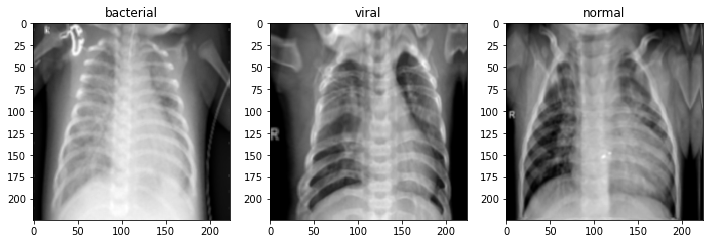

In [9]:
#function to perform augmentation
def get_alb_aug(X_train):
  aug_img = np.zeros(X_train.shape)
  for i in range(X_train.shape[0]):
    aug_img[i] = augm(image=X_train[i])['image']
  return aug_img

X_train_aug = get_alb_aug(X_train.copy())
plot_image(X_train_aug,y_train) #prints the images derived through Augmentation.
del(X_train_aug) #Deleting the variable, not used further to free up RAM

In [10]:
#get balance count
def get_balance(y_train):
  l = []
  for i in np.argmax(y_train, axis=1): # y_train
    if(i == 0):
      l.append("bacterial_pneumonia")
    elif(i == 1):
      l.append("viral_pneumonia")
    elif (i == 2):
      l.append("normal")
    else:
      l.append("unknown")
  balance = np.zeros(3)
  balance[0] = l.count("bacterial_pneumonia")
  balance[1] = l.count("viral_pneumonia")
  balance[2] = l.count("normal")
  balance = np.array(balance, dtype='uint32')
  return balance

In [11]:
#function to perform undersampling on the image data
def undersampling(X_train, y_train, target_num, shuffle):
  X_train_result = np.zeros((np.sum(target_num), img_size,img_size))
  y_train_result = np.zeros((np.sum(target_num), 3))

  if shuffle==1:
    s = np.arange(X_train.shape[0])
    np.random.shuffle(s)
    X_train = np.reshape(np.array(X_train, dtype=np.uint8)[s], (-1, img_size,img_size))
    y_train = y_train[s]
  
  idx=0
  i=0
  cnt = np.zeros(3)
  labels = np.argmax(y_train, axis=1)
  while(1):
    label = labels[i]
    i+=1
    if np.sum(cnt)==np.sum(target_num): break
    if idx==sum(target_num): break
    if i==5200: break
    if cnt[label]==target_num[label]:
      continue
    cnt[label]+=1
    X_train_result[idx]=np.reshape(X_train[i-1], (img_size,img_size))
    y_train_result[idx]=y_train[i-1]
    idx+=1

  return X_train_result, y_train_result

In [12]:
#function to perform oversampling on the image data
def oversampling(X_train, y_train, max_num, shuffle):

  balance = get_balance(y_train)
  target_num = np.array([max_num-balance[0], max_num-balance[1], max_num-balance[2]],dtype='uint32')

  X_train_u, y_train_u = undersampling(X_train.copy(), y_train.copy(), target_num, shuffle)

  balance = get_balance(y_train_u)

  X_train_result = np.zeros((max_num,img_size,img_size))
  y_train_result = np.zeros((max_num,3))
  X_train_result = np.concatenate([X_train, X_train_u])
  y_train_result = np.concatenate([y_train, y_train_u])

  return X_train_result, y_train_result

bacterial_pneumonia / viral_pneumonia / normal / unknown
2530  /  2530  /  2530  /  0


C:\Users\panka\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


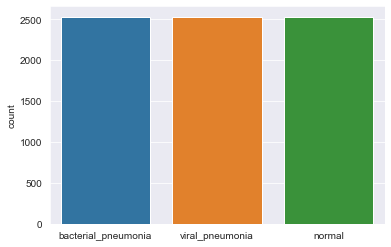

In [13]:
X_train_osamp, y_train_osamp = oversampling(X_train, y_train,2530 , 0)#Perform oversampling and make equal number of images of all 3 classes

data_balance_graph(y_train_osamp,1)#Plot graph to show the number of images of each class
del(X_train_osamp)
del(y_train_osamp)

In [14]:
!wandb login
#Important - wandb used for model development and evaluation. Create account and login for execution.

wandb: Currently logged in as: sharukh (use `wandb login --relogin` to force relogin)


wandb: You can find your API key in your browser here: https://wandb.ai/authorize

wandb: Paste an API key from your profile and hit enter:

In [15]:
#Defining model training metrics
early_stopping =EarlyStopping(monitor="val_loss",
                         min_delta = .001,
                         patience=6,
                         mode="auto",
                         verbose=1,
                         restore_best_weights = True
                        ) #Stop training when val_loss has stopped improving.

Learning_rate_reduction=ReduceLROnPlateau(monitor='accuracy',
                                          factor=0.5,
                                          patience=5, 
                                          verbose=1, 
                                          min_delta = 0.01
                                          ) #Reduce learning rate when val_accuracy stops improving

checkpoint = ModelCheckpoint(filepath='/Users/panka/Sharukh Project/chest_xray/checkpoint/{epoch:02d}-{accuracy:.5f}.h5',
                        save_weights_only=True, 
                        save_best_only = True,
                        verbose=1, 
                        mode='min', 
                        monitor='loss'
                        )#Callback to save the Keras model

Use - appropriate path or else error will be given - /Users/panka/Sharukh Project/chest_xray/checkpoint

#### Defining our Model

In [16]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

with tf.device('/device:GPU:0'): 
  def build_model():
      img_input = tf.keras.Input(shape=(img_size, img_size,1), name='ImageInput')
      img_conc = tf.keras.layers.Concatenate()([img_input, img_input, img_input])

     #Creating the base pre-trained model
      base_model = ResNet50( weights='imagenet', include_top=False, input_tensor=img_conc )
      for layer in base_model.layers[:144]: 
          layer.trainable = False  

      for i, layer in enumerate(base_model.layers):
        print(i, layer.name, "-", layer.trainable)

      # adding a global spatial average pooling layer
      x = base_model.output
      x = GlobalAveragePooling2D()(x) 
      x = BatchNormalization(name='batchNorm1')(x)
      x = Dense(128, activation='relu', name='fc1', kernel_regularizer=keras.regularizers.l2(0.001))(x)
      x = Dropout(0.5, name='dropout1')(x)   
      x = BatchNormalization(name='batchNorm2')(x)
      x = Dense(64, activation='relu', name='fc2',kernel_regularizer=keras.regularizers.l2(0.001))(x) 
      x = Dropout(0.5, name='dropout2')(x) 
      x = BatchNormalization(name='batchNorm3')(x)
      x = Dense(64, activation='relu', name='fc3',kernel_regularizer=keras.regularizers.l2(0.001))(x) 
      x = Dropout(0.5, name='dropout3')(x) 
        
      predictions = Dense(3, activation='softmax', name='fc4')(x) 
    
      model = Model(inputs=img_input, outputs=predictions)
      return model

In [18]:
# Setting the parameters for the model
run = wandb.init(project='Final_AIAS',
                config={  
                    "learning_rate": 0.0001,
                    "epochs": 50,
                    "batch_size": 32,
                    "loss_function": "categorical_crossentropy",
                    "architecture": "RenNet-50",
                    "dataset": "original+augm*3((balanced))"
                })
config = wandb.config  #Using it to configure the model
callbacks=[Learning_rate_reduction, checkpoint, WandbCallback()]
tf.keras.backend.clear_session()


In [19]:
X = np.concatenate([X_train, X_val])
Y = np.concatenate([y_train, y_val])

skf = KFold(n_splits=9, shuffle=True)
accuracy = []
test_loss_list=[]
test_score_list = []


# call the build_model()
model = build_model()
optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
model.compile(optimizer=optimizer,
              loss = config.loss_function,
              metrics = ['accuracy']
              )


# Original Dataset
print('Original Dataset')
X_model_train = X[train]
y_model_train = Y[train]
print('      X_model_train:',X_model_train.shape)
print('      y_model_train:',y_model_train.shape)

# Performing Oversampling
print('>> Oversampling')
balance = get_balance(y_model_train)
max_num = np.max(balance)
X_model_train_oversampled = np.zeros((max_num*3,img_size,img_size))
y_model_train_oversampled = np.zeros((max_num*3,3))
X_model_train_oversampled, y_model_train_oversampled = oversampling(X_model_train, y_model_train, max_num, 0)

print('after oversampling')
print('   X_model_train_oversampled',X_model_train_oversampled.shape)
print('   y_model_train_oversampled',y_model_train_oversampled.shape)
print()

0 ImageInput - False
1 concatenate - False
2 conv1_pad - False
3 conv1_conv - False
4 conv1_bn - False
5 conv1_relu - False
6 pool1_pad - False
7 pool1_pool - False
8 conv2_block1_1_conv - False
9 conv2_block1_1_bn - False
10 conv2_block1_1_relu - False
11 conv2_block1_2_conv - False
12 conv2_block1_2_bn - False
13 conv2_block1_2_relu - False
14 conv2_block1_0_conv - False
15 conv2_block1_3_conv - False
16 conv2_block1_0_bn - False
17 conv2_block1_3_bn - False
18 conv2_block1_add - False
19 conv2_block1_out - False
20 conv2_block2_1_conv - False
21 conv2_block2_1_bn - False
22 conv2_block2_1_relu - False
23 conv2_block2_2_conv - False
24 conv2_block2_2_bn - False
25 conv2_block2_2_relu - False
26 conv2_block2_3_conv - False
27 conv2_block2_3_bn - False
28 conv2_block2_add - False
29 conv2_block2_out - False
30 conv2_block3_1_conv - False
31 conv2_block3_1_bn - False
32 conv2_block3_1_relu - False
33 conv2_block3_2_conv - False
34 conv2_block3_2_bn - False
35 conv2_block3_2_relu - False

In [20]:
# Performing Augmentation 
print('>> Augmentation1')
X_aug_train1 = np.stack(get_alb_aug(X_model_train_oversampled)).reshape(-1, img_size, img_size).astype('float32')
X_aug_train2 = np.stack(get_alb_aug(X_model_train_oversampled)).reshape(-1, img_size, img_size).astype('float32')
print('      X_aug_train1:',X_aug_train1.shape)
print('      X_aug_train2:',X_aug_train2.shape)
X_model_train = np.concatenate([X_model_train, X_aug_train1, X_aug_train2]) 
del(X_aug_train1)
del(X_aug_train2)
y_model_train = np.concatenate([y_model_train, y_model_train_oversampled, y_model_train_oversampled]) 
print('      X_model_train:',X_model_train.shape)
print('      y_model_train:',y_model_train.shape)

>> Augmentation1
      X_aug_train1: (7590, 224, 224)
      X_aug_train2: (7590, 224, 224)
      X_model_train: (20380, 224, 224)
      y_model_train: (20380, 3)


In [21]:
print('>> Augmentation2')
X_aug_train3 = np.stack(get_alb_aug(X_model_train_oversampled)).reshape(-1, img_size, img_size).astype('float32')
print('      X_aug_train3:',X_aug_train3.shape)
del(X_model_train_oversampled)
X_model_train = np.concatenate([X_model_train, X_aug_train3])
del(X_aug_train3)
y_model_train = np.concatenate([y_model_train, y_model_train_oversampled])
del(y_model_train_oversampled)
print('      X_model_train:',X_model_train.shape)
print('      y_model_train:',y_model_train.shape)

>> Augmentation2
      X_aug_train3: (7590, 224, 224)
      X_model_train: (27970, 224, 224)
      y_model_train: (27970, 3)


In [22]:
# Performing Undersampling
print('>> Undersampling')
balance = get_balance(y_model_train)
max_num = np.max(balance)
target_num = np.array([max_num-balance[0], max_num-balance[1], max_num-balance[2]],dtype='uint32')
print('      max_num:',max_num)
print('      target_num:',target_num)
X_model_train_u =  np.zeros((np.sum(target_num),img_size,img_size))
print('      X_model_train_u:',X_model_train_u.shape)
y_model_train_u =  np.zeros((np.sum(target_num),3))
X_model_train_u, y_model_train_u = undersampling(X_model_train.copy(), y_model_train.copy(), target_num, 0)
print('      X_model_train_u:',X_model_train_u.shape)
print('      y_model_train_u:',y_model_train_u.shape)

>> Undersampling
      max_num: 10120
      target_num: [   0 1201 1189]
      X_model_train_u: (2390, 224, 224)
      X_model_train_u: (2390, 224, 224)
      y_model_train_u: (2390, 3)


In [23]:
# Concatenating the results
print('>> final Concatenate ')
X_model_train = np.concatenate([X_model_train, X_model_train_u])
del(X_model_train_u)
y_model_train = np.concatenate([y_model_train, y_model_train_u])
del(y_model_train_u)
print('      X_model_train:',X_model_train.shape)
print('      y_model_train:',y_model_train.shape)


>> final Concatenate 
      X_model_train: (30360, 224, 224)
      y_model_train: (30360, 3)


In [24]:
X_model_val = X_val
y_model_val = y_val

print('data size: ', X_model_train.shape[0])
print('batch_size: ',config.batch_size)
print('nb_epochs: ',config.epochs)
print('nb_train_steps: ', X_model_train.shape[0]//config.batch_size)
print()
import warnings
warnings.filterwarnings('ignore')


data size:  30360
batch_size:  32
nb_epochs:  50
nb_train_steps:  948



#### Run

In [25]:
print("-----Start-----")
 
history = model.fit(X_model_train, y_model_train,
                        epochs=config.epochs,
                        batch_size = config.batch_size,
                        validation_data = (X_model_val, y_model_val),
                        validation_steps = 5,
                        callbacks = callbacks)

run.join()

-----Start-----
Epoch 1/50
949/949 [==============================] - ETA: 0s - loss: 1.3234 - accuracy: 0.5591WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 5 batches). You may need to use the repeat() function when building your dataset.

Epoch 00001: loss improved from inf to 1.32337, saving model to /Users/panka/Sharukh Project/chest_xray/checkpoint\01-0.55912.h5
949/949 [==============================] - 1164s 1s/step - loss: 1.3234 - accuracy: 0.5591 - val_loss: 1.9570 - val_accuracy: 0.3750 - lr: 1.0000e-04
Epoch 2/50
949/949 [==============================] - ETA: 0s - loss: 1.0901 - accuracy: 0.6555
Epoch 00002: loss improved from 1.32337 to 1.09010, saving model to /Users/panka/Sharukh Project/chest_xray/checkpoint\02-0.65550.h5
949/949 [==============================] - 1159s 1s/step - loss: 1.0901 - accuracy: 0.6555 - lr: 1.0000e-04
Epoch 3

Epoch 49/50
949/949 [==============================] - ETA: 0s - loss: 0.3570 - accuracy: 0.8684
Epoch 00049: loss improved from 0.35706 to 0.35697, saving model to /Users/panka/Sharukh Project/chest_xray/checkpoint\49-0.86841.h5
949/949 [==============================] - 1153s 1s/step - loss: 0.3570 - accuracy: 0.8684 - lr: 1.2500e-05
Epoch 50/50
949/949 [==============================] - ETA: 0s - loss: 0.3517 - accuracy: 0.8698
Epoch 00050: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00050: loss improved from 0.35697 to 0.35166, saving model to /Users/panka/Sharukh Project/chest_xray/checkpoint\50-0.86983.h5
949/949 [==============================] - 1153s 1s/step - loss: 0.3517 - accuracy: 0.8698 - lr: 1.2500e-05


accuracy,▁▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▆▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
lr,████████████████▄▄▄▄▄▄▄▄▄▄▄▄▂▂▂▂▂▂▂▂▁▁▁▁
val_accuracy,▁
val_loss,▁
accuracy,0.86983
best_epoch,0
best_val_loss,1.95701
epoch,49
loss,0.35166


#### Validation - Accuracy & Loss vs Epochs

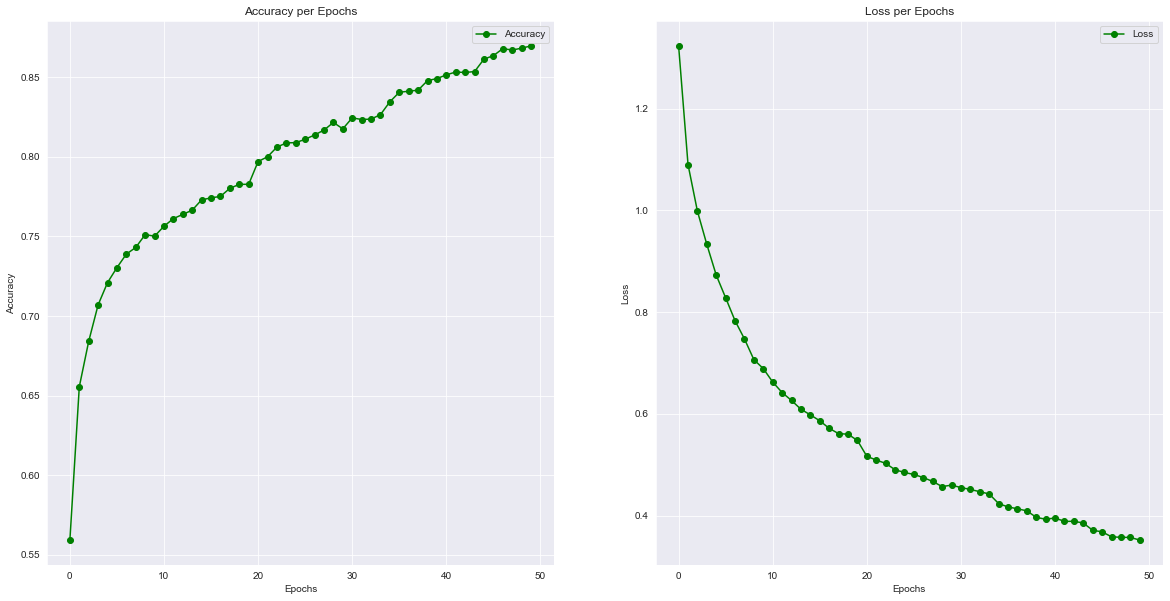

In [56]:
epochs = [i for i in range(50)] 
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Accuracy')
ax[0].set_title('Accuracy per Epochs')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Loss')
ax[1].set_title('Loss per Epochs')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

#### Validation - Precision & Recall

In [7]:
y_pred = model.predict(X_val)
cm = confusion_matrix(np.argmax(y_val, axis=1),
                      np.argmax(y_pred, axis=1))
cm = pd.DataFrame(cm , index = ['0','1','2,'] , columns = ['0','1','2'])

bb, bv, bn, vb, vv, vn, nb, nv, nn = cm.values.ravel()

precision_b = bb/(bb+vb+nb) 
recall_b = bb/(bn+bv+bb)

precision_v = vv/(bv+vv+nv) 
recall_v = vv/(vn+vv+vb)

precision_n = nn/(bn+vn+nn) 
recall_n = nn/(nn+nv+nb)


print("Precision_bacterial of the model is {:.2f}".format(precision_b))
print("Recall_bacterial of the model is {:.2f}\n".format(recall_b))

print("Precision_viral of the model is {:.2f}".format(precision_v))
print("Recall_viral of the model is {:.2f}\n".format(recall_v))

print("Precision_normal of the model is {:.2f}".format(precision_n))
print("Recall_normal of the model is {:.2f}\n".format(recall_n))

Precision_bacterial of the model is 0.82
Recall_bacterial of the model is 0.87

Precision_viral of the model is 0.79
Recall_viral of the model is 0.71

Precision_normal of the model is 0.95
Recall_normal of the model is 0.93

